### Replay composition 
Analysis 1: (past no reward,previous reward,future)

In [448]:
%reload_ext autoreload
%autoreload 2

In [449]:
import spyglass as nd
import pandas as pd
import statsmodels.api as sm
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import multiprocessing

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common.common_interval import _intersection

import spyglass.spikesorting as ss
from spyglass.spikesorting import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
from spyglass.decoding.clusterless import (UnitMarks,
                                           UnitMarkParameters,UnitMarksIndicatorSelection,
                                          UnitMarksIndicator)
from spyglass.common.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection


# Here are the analysis tables specific to Shijie Gu
from spyglass.Analysis_SGU import (TrialChoice,
                                   TrialChoiceReplay,
                                   RippleTimes,
                                   Decode,get_linearization_map,
                                   find_ripple_times,classify_ripples,classify_ripple_content,
                                   get_df_tally,find_tally_df)

In [450]:
def count_replay_by_category(replay_df,tally_df,category_names):
    '''
    replay_df is a list (of length trials) of list (arm replays on each trial)
    tally_df is a dataframe that has corresponence between arm and category
    '''
    # initialize 
    category={}
    for n in category_names:
        category[n]=0
    # add in nan
    nan_count=0
    
    # do counting
    for t in range(len(replay_df)):
        replay=replay_df[t]
        nan_count+=np.sum(np.isnan(replay))
        if len(replay)==0:
            continue
        for c in list(category.keys()):
            category[c]+=np.sum(replay==tally_df.loc[tally_df.index[t],c])
    category['nan']=nan_count
    return category

In [451]:
def unravel_replay(replay_list):
    replay_df=[]
    for t in range(len(replay_list)):
        replay_t=replay_list[t]
        replay_t_unraveled=[]
        for ri in range(len(replay_t)):
            for seg in replay_t[ri]:
                replay_t_unraveled.append(seg)
        replay_df.append(replay_t_unraveled)
    return replay_df

In [460]:
def replay_in_categories(nwb_copy_file_name,epoch_num):
    # get all replay
    key={'nwb_file_name':nwb_copy_file_name,'epoch':epoch_num}
    replay_df_all=pd.DataFrame((TrialChoiceReplay & key).fetch1('choice_reward_replay'))

    '''HOME replay'''
    categories=['current','past','past_reward']
        # find trials where categories are distinct arms
    behav_df_H=find_tally_df(nwb_file_name,epoch_num,categories)
        # get replays on these trials
    subset_ind=np.intersect1d(behav_df_H.index,replay_df_all.index)
    replay_H=list(replay_df_all.loc[subset_ind,'replay_H'])
    replay_df_H=unravel_replay(replay_H)
    category_H=count_replay_by_category(replay_df_H,behav_df_H,categories)

    '''OUTER replay'''
    categories=['future','past','past_reward']
        # find trials where categories are distinct arms
    behav_df_O=find_tally_df(nwb_file_name,epoch_num,categories)
        # get replays on these trials
    subset_ind=np.intersect1d(behav_df_O.index,replay_df_all.index)
    replay_O=list(replay_df_all.loc[subset_ind,'replay_O'])
    replay_df_O=unravel_replay(replay_O)
    category_O=count_replay_by_category(replay_df_O,behav_df_O,categories)
    
    return category_H,category_O

### Simulate random replay:
call ```bootstrap_random()```

In [453]:
def simulate_random_replay(n_category,tally_df,replay_df):
    '''
    simulate random replay
    
    INPUT: 
    n_category: number of categories
    tally_df: a dataframe that has corresponence between arm and category
    
    OUTPUT:
    A dictionary of {category: number of replays}
    
    '''
    replay_df_random=[np.random.choice(np.array([1,2,3,4]), # 4 arms
                                       len(replay_df[t])) 
                      for t in range(len(replay_df))]

    replay_category=count_replay_by_category(replay_df_random,
                                             tally_df,category_names)
    return replay_category

In [454]:
def bootstrap_random(tally_df,replay_df,category_names,p_value):
    '''
    RETURNS:
    prop_mean: # of category
    prop_CI: # of category x 2
    '''
    n_category=len(category_names)

    B=10000
    count_boot=np.zeros((B,n_category))
    for b in range(B):
        replay_category=simulate_random_replay(n_category,tally_df)
        for i in range(n_category):
            count_boot[b,i]=replay_category[category_names[i]]

    # make into proportion
    prop_boot=count_boot/np.sum(count_boot,axis=1).reshape((-1,1))
    prop_mean=np.mean(prop_boot,axis=0)

    prop_CI=np.zeros((n_category,2))
    for i in range(n_category):
        prop_CI[i,:]=np.quantile(prop_boot[:,i],[p_value,1-p_value])
    return prop_mean,prop_CI

In [455]:
# the only cell to be edited
nwb_file_name = 'molly20220418.nwb'

In [456]:
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
TrialChoice & {'nwb_file_name':nwb_copy_file_name}

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),"epoch_name session name, get from IntervalList","choice_reward pandas dataframe, choice"
molly20220418_.nwb,2,02_Seq2Session1,=BLOB=
molly20220418_.nwb,4,04_Seq2Session2,=BLOB=
molly20220418_.nwb,6,06_Seq2Session3,=BLOB=
molly20220418_.nwb,8,08_Seq2Session4,=BLOB=
molly20220418_.nwb,10,10_Seq2Session5,=BLOB=


In [196]:
epochs=(TrialChoice & {'nwb_file_name':nwb_copy_file_name}).fetch('epoch')

### test on one session

#### 1. subset trials analysis

In [537]:
epoch_num=10
category_H,category_O=replay_in_categories(nwb_copy_file_name,epoch_num)

epoch name 10_Seq2Session5
number of valid trials: 33
epoch name 10_Seq2Session5
number of valid trials: 23


In [538]:
category_H

{'current': 5, 'past': 6, 'past_reward': 10, 'nan': 32}

In [539]:
category_O

{'future': 17, 'past': 30, 'past_reward': 14, 'nan': 7}

#### 2. all trials with GLM

In [585]:
def GLM_replay(nwb_file_name,epoch_num,replay_location,categories,plot_categories):
    '''
    replay_location: 'replay_H' or 'replay_O'
    '''

    nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)

    betas={}

    # get all replay
    key={'nwb_file_name':nwb_copy_file_name,'epoch':epoch_num}
    replay_df_subset=pd.DataFrame((TrialChoiceReplay & key).fetch1('choice_reward_replay'))

    # get behavior
    behavior_df=get_df_tally(nwb_file_name,epoch_num)

    # create regresser matrix
    if categories[0]=='home':
        y=np.zeros((5*len(replay_df_subset.index),1))
        x=np.zeros((5*len(replay_df_subset.index),len(categories)))
    else:
        y=np.zeros((4*len(replay_df_subset.index),1))
        x=np.zeros((4*len(replay_df_subset.index),len(categories)))

    for i in range(len(replay_df_subset.index)):
        t=replay_df_subset.index[i]
        print(t)

        replay=np.array(unravel_replay([list(replay_df_subset.loc[t,replay_location])])[0])
        print(replay)
        if categories[0]=='home':
            for a in range(4):
                arm=a+1
                y[i*5+a+1,0]=np.sum(replay==arm)
            for c in range(1,len(categories)):
                correponding_arm=behavior_df.loc[t,categories[c]]
                if not np.isnan(correponding_arm):
                    x[i*5+int(correponding_arm),c]=1
            # home
            x[i*5,0]=1
            y[i*5,0]=np.sum(replay==0)
        else:
            for a in range(4):
                arm=a+1
                y[i*4+a,0]=np.sum(replay==arm)
            for c in range(len(categories)):
                correponding_arm=behavior_df.loc[t,categories[c]]
                if not np.isnan(correponding_arm):
                    x[i*4+int(correponding_arm)-1,c]=1
    
            
    
    # do GLM
    x_ = sm.add_constant(x)
    glm_poisson = sm.GLM(y,x_,family=sm.families.Poisson())
    res = glm_poisson.fit()
    CI=res.conf_int(alpha=0.05)
    print(res.summary())
    
    for c in range(len(plot_categories)):
        betas[plot_categories[c]]=(np.exp(res.params[c+1]),np.exp(CI[c+1])) #plus one because of the constant term
    
    return betas,behavior_df,replay_df_subset,x,y

In [586]:
categories=['current','past','past_reward']
plot_categories=['future','past','past_reward']
replay_location='replay_H'
betas,behavior_df,replay_df_subset,x,y=GLM_replay(nwb_file_name,epoch_num,replay_location,categories,plot_categories)

epoch name 10_Seq2Session5
1
[ 4.  0.  0.  5. nan  1. nan  5.  2.  0.  5.]
4
[0 0 0]
5
[0 0 1 0 0 0]
6
[0 2 0]
7
[0 0 0]
8
[0 0 0 4]
9
[0 2 0 0]
10
[ 0.  0.  4. nan  1.]
11
[0 0 0 0]
12
[ 0.  0.  0.  2. nan  5.  0.]
13
[0 1]
14
[0 0 0 0]
15
[]
16
[nan  0.  1.  1.  0.]
17
[0]
18
[0 0 0]
19
[]
20
[ 0. nan  1.  0.]
21
[ 0.  0.  2.  0. nan  5.  0.]
22
[5]
23
[ 0.  0.  0.  0. nan  5.  0.]
24
[ 0.  3.  1. nan  4.  0.  0.]
25
[]
26
[0]
27
[nan]
28
[0 0 1]
29
[]
30
[ 3. nan  0.]
31
[ 0.  0.  0.  0. nan  0.  0.]
32
[0 2 1 0 0]
33
[ 0.  0.  0.  4. nan  5.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
34
[0 1]
35
[0 0 0]
36
[ 0.  0.  0. nan  0.  5.  0.  0.]
37
[0 0 0 0]
38
[ 2.  0.  0.  3.  1. nan  0.]
39
[ 0.  0. nan  2.  0. nan  5. nan  0.  0.  0.]
40
[nan  0.  0.  4. nan  1.]
41
[ 0.  0.  0.  0.  0. nan  0.  5. nan  0.]
42
[3 0 0 0 0 3]
43
[1 5]
44
[ 0.  5. nan  5.  0. nan  5.  0.]
45
[0 2]
46
[0 0 0 0 0]
47
[ 0.  1. nan  5. nan  0.  0.]
48
[0 2 0]
49
[0 0 4 0]
50
[ 0. nan  1. nan  2.  2.  2.]
51
[ 0. 

In [578]:
replay_df_subset.index[70]

75

In [587]:
replay_df_subset.loc[75,'replay_H']

[[0], [0], array([ 0., nan,  5.,  0.]), [0, 5], [0, 5], [0], [1]]

In [548]:
categories=['current','past','past_reward']
plot_categories=['future','past','past_reward']
replay_location='replay_H'
betas_H=GLM_replay(nwb_file_name,epoch_num,replay_location,categories,plot_categories)

categories=['home','future','past','past_reward']
plot_categories=['home','future arm','past','past_reward']
replay_location='replay_O'
betas_O=GLM_replay(nwb_file_name,epoch_num,replay_location,categories,plot_categories)


epoch name 10_Seq2Session5
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  308
Model:                            GLM   Df Residuals:                      304
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -181.80
Date:                Sat, 09 Jul 2022   Deviance:                       214.92
Time:                        09:40:58   Pearson chi2:                     284.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07495
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1427    

In [549]:
betas_H

{'future': (1.1883664016914461, array([0.74057  , 1.9069294])),
 'past': (0.1917847236961159, array([0.06726501, 0.54681294])),
 'past_reward': (0.7532026138897236, array([0.3738215 , 1.51760713]))}

In [550]:
betas_O

{'home': (0.08123214354739493, array([0.04995985, 0.13207928])),
 'future arm': (0.04487924818613003, array([0.02228033, 0.09040023])),
 'past': (0.031921681624947226, array([0.01022826, 0.09962529])),
 'past_reward': (0.0730745795572615, array([0.03019477, 0.17684833]))}

In [ ]:
'''simulate random'''

In [134]:
def bootstrap_random_session(epoch_num):
    tally_df=find_tally_df(nwb_file_name,epoch_num,category_names)
    p_value=0.025
    prop_mean,prop_CI=bootstrap_random(tally_df,category_names,p_value)
    return prop_mean,prop_CI

In [154]:
category_names=['current','future','past','past_reward']

with multiprocessing.Pool(5) as p:
    results=p.map(bootstrap_random_session,[s for s in epochs])

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/connection.py:341: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/connection.py:341: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/connection.py:341: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/connection.py:341: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")
/home/shijiegu/anaconda3/envs/spyglass/l

epoch name epoch nameepoch name08_Seq2Session4 
06_Seq2Session3epoch name 04_Seq2Session2 

epoch name 10_Seq2Session502_Seq2Session1number of valid trials: 19
number of valid trials: 21


number of valid trials: 11number of valid trials: 16

number of valid trials: 15


In [180]:
mean_random=np.concatenate([results[i][0].reshape((1,-1)) 
                            for i in range(len(results))],axis=0) # session by n_category
std_down_random=np.concatenate([results[i][1][:,0].reshape((1,-1)) 
                            for i in range(len(results))],axis=0) # session by n_category
std_up_random=np.concatenate([results[i][1][:,1].reshape((1,-1)) 
                            for i in range(len(results))],axis=0) # session by n_category

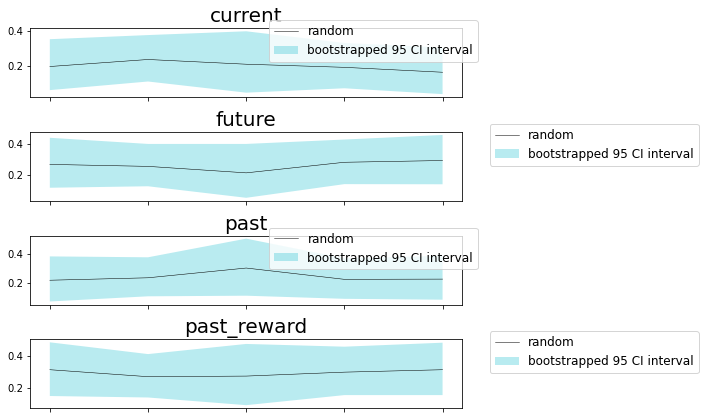

In [185]:
fig,axes=plt.subplots(len(category_names),1,figsize=(12, 12))
for c in range(len(category_names)):
    # plot random mean
    axes[c].plot(mean_random[:,c],'-k',linewidth=0.5,label='random')
    #axes[c].plot(,'*',color='C0')
    
    axes[c].fill_between(np.arange(len(std_up_random)),
                         std_up_random[:,c],std_down_random[:,c],facecolor='C9', alpha=0.3,label='bootstrapped 95 CI interval')
    significant_ind=np.argwhere(np.logical_or(
        mean_random[:,c]>(std_up_random[:,c]),
        mean_random[:,c]<(std_down_random[:,c])))
    #significant_ind=np.argwhere(np.logical_or(
    #    mean_data[:,c]>(std_up_random[:,c]),
    #    mean_data[:,c]<(std_down_random[:,c]))
    axes[c].plot(significant_ind,np.ones_like(significant_ind),'+',color='k')
        
    axes[c].set_position([0.06,1-(c+1)*0.12-0.05,0.5,0.08])
    axes[c].legend(fontsize=12,bbox_to_anchor=(1.05, 1.2))
    
    axes[c].set_xticks(np.arange(len(mean_random[:,c])));
    axes[c].set_xticklabels('',fontsize=16);
    axes[c].set_title(category_names[c],fontsize=20)
    
#plt.savefig(os.path.join(figurefolder,'C_Markovianess_'+animal+'.png'),bbox_inches='tight',dpi=500)
    